# Imports

In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Define Path and Read Sample Files

In [31]:
data_path = '../data/'
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
print("Files detected:", len(files), "→", files[:3])

# reading first 2 files to get the schema
sample_files = files[:2]
# sample_files = files
df_list = []
for f in sample_files:
    print(f"Reading {f} ...")
    df_temp = pd.read_csv(os.path.join(data_path, f), low_memory=False)
    df_temp['__source'] = f
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)
print("Combined shape:", df.shape)

Files detected: 8 → ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv']
Reading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv ...
Reading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv ...
Reading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv ...
Combined shape: (512212, 80)
Combined shape: (512212, 80)


# Initial Inspection for Basic Information

In [19]:

print("\n--- Basic Info ---\n")
print(df.info())
print("\nColumns:\n", df.columns.tolist()[:15])


--- Basic Info ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 80 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   

# Summary Statistics (sample)

In [20]:
print("\n--- Summary Statistics (sample) ---\n")
display(df.describe(include='all').T.head(10))


--- Summary Statistics (sample) ---



q:\MiniConda\envs\dsc\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
q:\MiniConda\envs\dsc\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Destination Port,2830743.0,NaN,NaN,NaN,8071.482501,18283.632172,0.0,53.0,80.0,443.0,65535.0
Flow Duration,2830743.0,NaN,NaN,NaN,14785663.929522,33653744.085855,-13.0,155.0,31316.0,3204828.5,119999998.0
Total Fwd Packets,2830743.0,NaN,NaN,NaN,9.36116,749.672792,1.0,2.0,2.0,5.0,219759.0
Total Backward Packets,2830743.0,NaN,NaN,NaN,10.39377,997.388269,0.0,1.0,2.0,4.0,291922.0
Total Length of Fwd Packets,2830743.0,NaN,NaN,NaN,549.302415,9993.589229,0.0,12.0,62.0,187.0,12900000.0
Total Length of Bwd Packets,2830743.0,NaN,NaN,NaN,16162.642546,2263088.051726,0.0,0.0,123.0,482.0,655453030.0
Fwd Packet Length Max,2830743.0,NaN,NaN,NaN,207.599941,717.184842,0.0,6.0,37.0,81.0,24820.0
Fwd Packet Length Min,2830743.0,NaN,NaN,NaN,18.713656,60.339345,0.0,0.0,2.0,36.0,2325.0
Fwd Packet Length Mean,2830743.0,NaN,NaN,NaN,58.201939,186.091157,0.0,6.0,34.0,50.0,5940.857143
Fwd Packet Length Std,2830743.0,NaN,NaN,NaN,68.910134,281.187092,0.0,0.0,0.0,26.162951,7125.596846


In [21]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

##### Artifact discovery

In [22]:
# Artifact verification: flow timeout cap
time_features = [' Flow Duration','Idle Mean',' Idle Max',' Active Max']
max_durations = []
for f in time_features:
    max_duration = df[f].max()
    max_duration_in_seconds =max_duration/1e6
    max_durations.append((f.strip(),max_duration,max_duration_in_seconds))
    print(f"{f}: max = {max_duration}  (units: microseconds) -> {max_duration_in_seconds} seconds")

 Flow Duration: max = 119999998  (units: microseconds) -> 119.999998 seconds
Idle Mean: max = 120000000.0  (units: microseconds) -> 120.0 seconds
 Idle Max: max = 120000000  (units: microseconds) -> 120.0 seconds
 Active Max: max = 110000000  (units: microseconds) -> 110.0 seconds


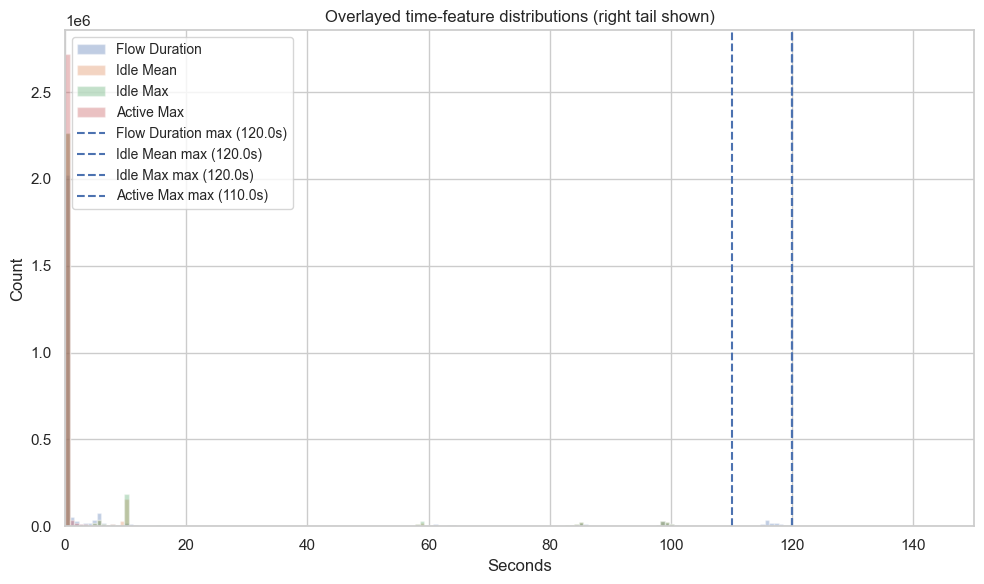

In [24]:
# Overlayed histograms for time features (use actual values from dataframe).
# We convert microseconds -> seconds for readability and plot the right tail (e.g. up to 150s).
plt.figure(figsize=(10,6))
bins = 200
range_seconds = (0, 150)  # show up to 150 seconds (adjust if needed)
# time_features is defined earlier in the notebook; max_durations holds tuples (name, max_value, max_seconds)
for col in time_features:
    if col in df.columns:
        vals = df[col].dropna() / 1e6  # convert microseconds -> seconds
        # plot histogram for this feature (semi-transparent so overlays are visible)
        plt.hist(vals, bins=bins, range=range_seconds, alpha=0.35, label=col.strip())
    else:
        # If a column name is slightly different, print a short debug message (won't break the plot)
        print(f'Column not found: {col}')
# draw vertical lines at the observed maxima (max_durations built earlier)
for name, max_val, max_sec in max_durations:
    # max_sec is already in seconds in the max_durations tuple created earlier
    plt.axvline(max_sec, linestyle='--', linewidth=1.5, label=f'{name} max ({max_sec:.1f}s)')
plt.xlabel('Seconds')
plt.ylabel('Count')
plt.title('Overlayed time-feature distributions (right tail shown)')
plt.xlim(range_seconds)
plt.legend(ncol=1, fontsize='small')
plt.tight_layout()
plt.show()

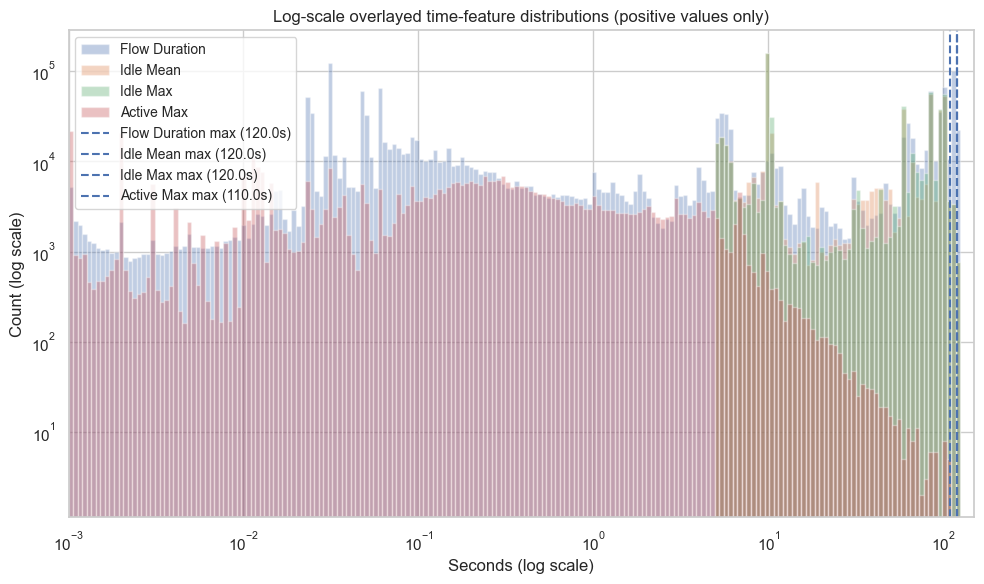

In [25]:
# Log-scale overlayed histograms for time features (values in seconds).
# Use log-spaced bins and log-x to reveal small differences across orders of magnitude.
# Filter out zeros/negatives because log scale is undefined for them.
plt.figure(figsize=(10,6))
# log-spaced bins from 1ms to 150s (adjust upper bound if you want a different right-tail cutoff)
bins = np.logspace(np.log10(1e-3), np.log10(150), 200)
for col in time_features:
    if col in df.columns:
        vals = (df[col].dropna() / 1e6).astype(float)  # microseconds -> seconds
        vals = vals[vals > 0]  # remove zeros/negatives for log-scale plotting
        if len(vals) == 0:
            print(f'No positive values for {col.strip()} — skipping')
            continue
        # histogram with log-spaced bins; alpha for visibility when overlaying
        plt.hist(vals, bins=bins, alpha=0.35, label=col.strip())
    else:
        print(f'Column not found: {col}')
# draw vertical dashed lines at observed maxima (max_durations built earlier)
ax = plt.gca()
for name, max_val, max_sec in max_durations:
    if max_sec > 0:
        ax.axvline(max_sec, linestyle='--', linewidth=1.5, label=f'{name} max ({max_sec:.1f}s)')
# set log scales and labels
ax.set_xscale('log')
ax.set_yscale('log')  # optional: comment out if you prefer linear counts
ax.set_xlabel('Seconds (log scale)')
ax.set_ylabel('Count (log scale)')
ax.set_title('Log-scale overlayed time-feature distributions (positive values only)')
ax.set_xlim(1e-3, 150)
ax.legend(ncol=1, fontsize='small')
plt.tight_layout()
plt.show()

# Missing and Infinite Value Analysis

## Missing Values

In [32]:
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("\nMissing Values Summary:")
print(missing.head(20))


Missing Values Summary:
Flow Bytes/s    19
dtype: int64


## Check for inf/-inf

In [33]:
inf_counts = np.isinf(df.select_dtypes(include=[np.number])).sum()
inf_counts = inf_counts[inf_counts > 0]
print("\nInfinite values detected:")
print(inf_counts)


Infinite values detected:
Flow Bytes/s       386
 Flow Packets/s    405
dtype: int64


# Data Type Classification

In [34]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
obj_cols = df.select_dtypes(include='object').columns.tolist()
print(f"\nNumeric columns: {len(num_cols)} | Object columns: {len(obj_cols)}")


Numeric columns: 78 | Object columns: 2


# Label Inspection

In [35]:
label_cols = [c for c in df.columns if 'label' in c.lower()]
print("\nPossible label columns:", label_cols)

if label_cols:
    label = label_cols[0]
    print("\nUnique label values")
    print(df[label].unique())
    print(df[label].value_counts().head(20))


Possible label columns: [' Label']

Unique label values
['BENIGN' 'DDoS' 'PortScan']
 Label
BENIGN      225255
PortScan    158930
DDoS        128027
Name: count, dtype: int64


# Outlier Glance on Numeric Features

q:\MiniConda\envs\dsc\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
q:\MiniConda\envs\dsc\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


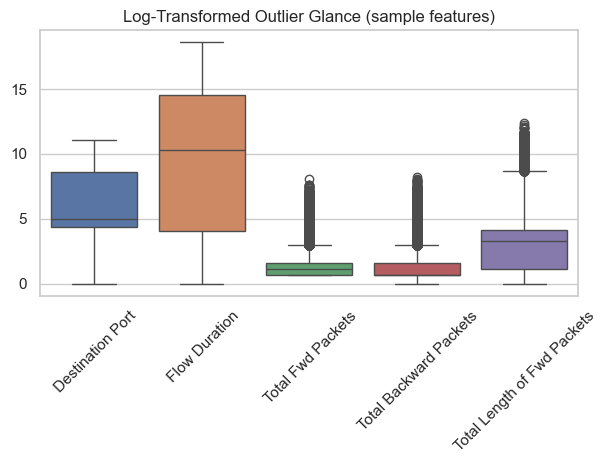

In [36]:
numeric_sample = df.select_dtypes(include=np.number).iloc[:, :5]
sns.boxplot(data=np.log1p(numeric_sample))
plt.title("Log-Transformed Outlier Glance (sample features)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Check for Duplicate Flow IDs (if exist)

In [37]:
flow_cols = [c for c in df.columns if 'flow id' in c.lower()]
if flow_cols:
    flow_col = flow_cols[0]
    dup_count = df[flow_col].duplicated().sum()
    print(f"\nDuplicate Flow IDs detected: {dup_count}")
else:
    print("\nNo Flow ID column detected or not standardised.")


No Flow ID column detected or not standardised.


# Class Balance Estimation (Raw)

In [38]:
if label_cols:
    label = label_cols[0]
    benign_count = df[df[label].str.contains('BENIGN', case=False, na=False)].shape[0]
    total = df.shape[0]
    print(f"\nApproximate Benign percentage: {round((benign_count/total)*100, 2)}%")


Approximate Benign percentage: 43.98%


# Save Profiling Summary

In [39]:
summary = {
    "total_rows": df.shape[0],
    "total_columns": df.shape[1],
    "num_numeric": len(num_cols),
    "num_object": len(obj_cols),
    "missing_columns": len(missing),
    "has_inf_values": len(inf_counts),
    "sample_files_analyzed": sample_files
}
pd.DataFrame([summary]).to_csv('../outputs/data_understanding_summary.csv', index=False)
print("Saved raw dataset profiling summary to outputs/data_understanding_summary.csv")

Saved raw dataset profiling summary to outputs/data_understanding_summary.csv
